In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sgutil, sgml

for i in [pd, np, sns, mpl]:
    print(i.__name__, i.__version__)

pandas 2.2.2
numpy 1.26.4
seaborn 0.13.2
matplotlib 3.8.4


In [2]:
# 주요 파일의 경로를 설정합니다.
data_path = 'data'
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'data.csv'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}
# fig, result cache 처리기를 생성합니다.
sc = sgutil.SGCache('img', 'result')
# 처리된 데이터를 불러옵니다.
df_train = pd.read_pickle(files['train_pkl'])
df_test = pd.read_pickle(files['test_pkl'])
df_org = pd.read_pickle(files['org_pkl'])
df_var = pd.read_pickle(files['var_pkl'])

# 변수를 유형별로 정리합니다.
target = 'Target'
X_cat = [i for i in df_var.loc[df_var['var_type'] == 'Categorical'].index.tolist() if i != target]
X_bool = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
X_ord = ['Application order', 'Previous qualification', "Mother's qualification", "Father's qualification"]
X_num = df_var.loc[(~df_var.index.isin(X_cat + X_bool + X_ord + [target]))].index.tolist()
X_all = X_cat + X_bool + X_ord + X_num

# Target

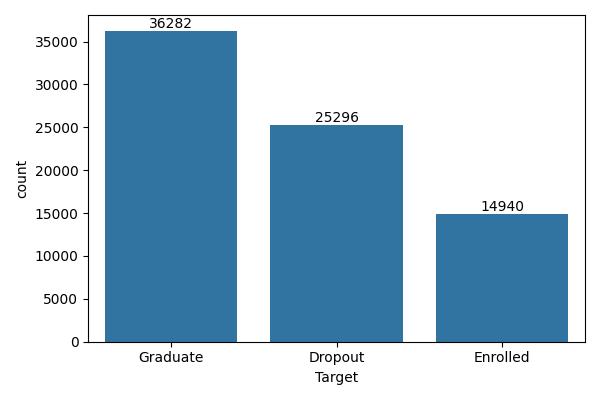

In [3]:
sc.cache_fig(
    'target_count',
    lambda x: [x.bar_label(i) for i in sns.barplot(df_train['Target'].value_counts(), ax=x).containers],
    figsize=(6, 4)
)

# Train과 Test의 차이

In [4]:
df_istrain = pd.concat([
    df_train.assign(is_train=1),
    df_test.assign(is_train=0)
], axis = 0)

In [5]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

def predict_is_train(m, df_valid, X):
    return pd.Series(m.predict_proba(df_valid[X])[:, 1], index=df_valid.index)
def eval_metric_is_train(y_true, prds):
    return roc_auc_score(y_true.sort_index()['is_train'], prds.sort_index())

is_train_result = sc.cache_result(
    'is_train_result',
    lambda : sgml.cv_model(
        StratifiedKFold(n_splits=5, random_state=123, shuffle=True), 
        lgb.LGBMClassifier, {'verbose': -1, 'n_estimators': 500}, df_istrain, X_cat + X_bool + X_ord + X_num, 'is_train',
        result_proc=sgml.lgb_learning_result,
        predict_func=predict_is_train, eval_metric = eval_metric_is_train,
        train_params={
            'valid_splitter': lambda x: train_test_split(x, train_size=0.9, stratify=x['is_train'], random_state=123),
            'fit_params': {'categorical_feature': X_cat, 'callbacks': [lgb.early_stopping(5, verbose=False)]},
            'valid_config_proc': sgml.gb_valid_config
        }
    )
)

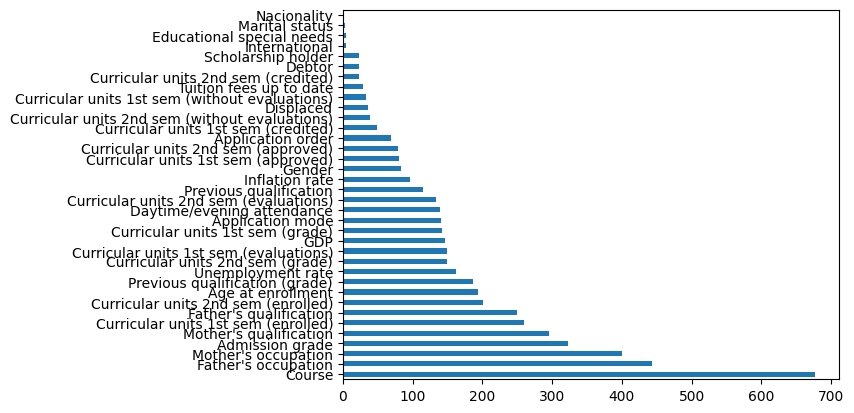

In [6]:
pd.concat([i[1] for i in is_train_result[3]], axis=1).mean(axis=1).sort_values(ascending=False).plot(kind='barh')
plt.show()

In [7]:
np.mean(is_train_result[1])

0.999879455793093

학습/평가 데이터를 분류하는 교차검증을 해본결과 

학습 데이터와 평가 데이터는 차이가 극명히 존재합니다. 살펴봅니다.

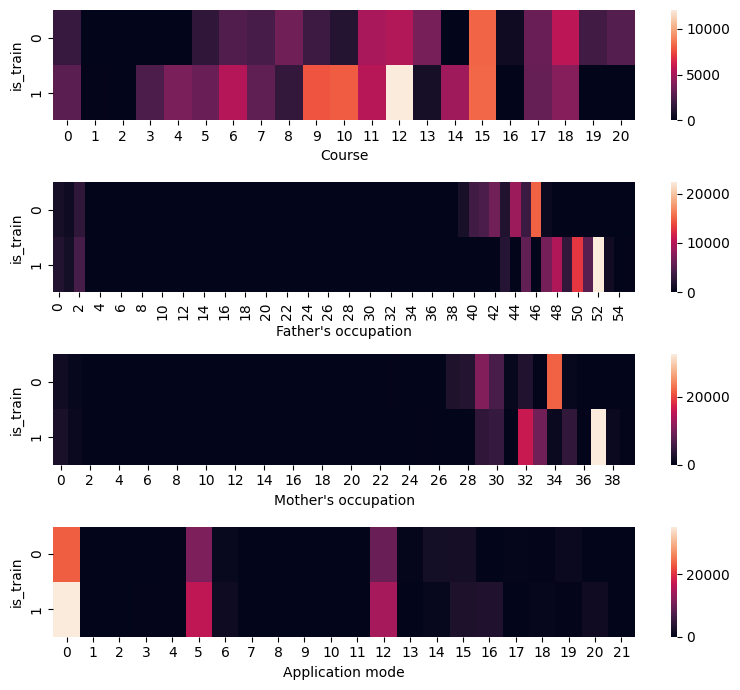

In [16]:
sc.cache_fig(
    'heat_map_cat',
    lambda x: [
        sns.heatmap(
            df_istrain.pivot_table(index='is_train', columns=i, aggfunc='size').fillna(0), ax=ax
        ) for i, ax in zip(['Course', "Father's occupation", "Mother's occupation", 'Application mode'], x)
    ], nrow=4, ncol=1, figsize=(8, 7), redraw=True
)
plt.show()

In [9]:
df_var.loc["Course", "Description"].iloc[0]

'33 - Biofuel Production Technologies 171 - Animation and Multimedia Design 8014 - Social Service (evening attendance) 9003 - Agronomy 9070 - Communication Design 9085 - Veterinary Nursing 9119 - Informatics Engineering 9130 - Equinculture 9147 - Management 9238 - Social Service 9254 - Tourism 9500 - Nursing 9556 - Oral Hygiene 9670 - Advertising and Marketing Management 9773 - Journalism and Communication 9853 - Basic Education 9991 - Management (evening attendance)'

In [10]:
df_var.loc["Father's occupation", "Description"].iloc[0]

'0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 101 - Armed Forces Officers 102 - Armed Forces Sergeants 103 - Other Armed Forces personnel 112 - Directors of administrative and commercial services 114 - Hotel, catering, trade and other services directors 121 - Specialists in the physical sciences, mathematics, engineering and related techniques 122 - Health professionals 123 - teachers 124 - Specialists in finance, accounting, administrative org

In [11]:
df_var.loc["Mother's occupation", "Description"].iloc[0]

'0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 122 - Health professionals 123 - teachers 125 - Specialists in information and communication technologies (ICT) 131 - Intermediate level science and engineering technicians and professions 132 - Technicians and professionals, of intermediate level of health 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 141 - Office workers, secretaries in general and 

이 변수들은 범주형으로 다루어서는 평가 데이터에 대한 예측 성능을 기대하기 힘들어 보입니다. 범주가 지닌 텍스트를 기반으로 접근을 해볼만합니다.

## 범주형 변수

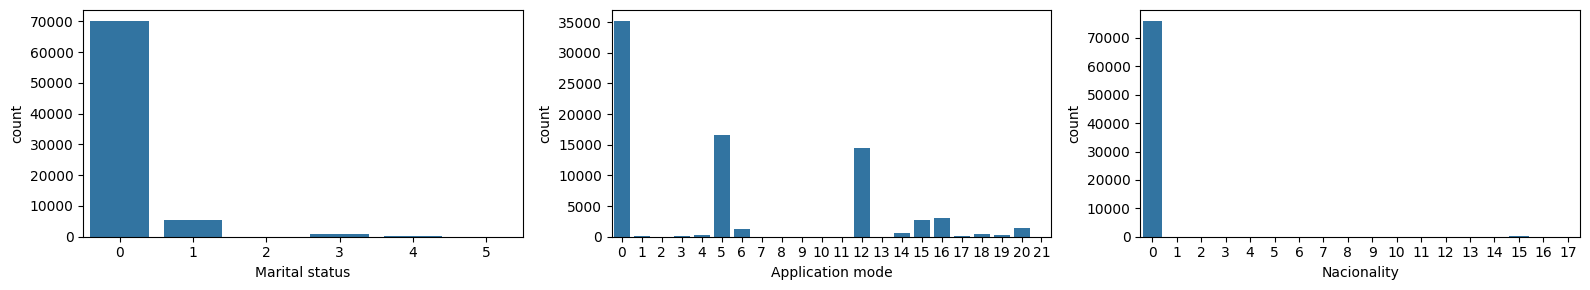

In [15]:
sc.cache_fig(
    'freq_plot_1', 
    lambda x: [sns.barplot(df_train[i].value_counts(), ax=ax) 
     for ax, i in zip(x, ['Marital status', 'Application mode', 'Nacionality'])],
    nrow=1, ncol=3, figsize=(16, 3)
)   

### Marital status

In [36]:
pd.concat([
    pd.crosstab(
        index=df_train['Marital status'], columns=df_train[target], normalize='index'
    ), df_train['Marital status'].value_counts()
], axis=1)

,Graduate,Dropout,Enrolled,count
Marital status,,,,
0,0.490490,0.309536,0.199974,70189
1,0.300793,0.560423,0.138784,5296
2,0.437500,0.437500,0.125000,16
3,0.242494,0.587760,0.169746,866
4,0.344828,0.543103,0.112069,116
5,0.142857,0.657143,0.200000,35


In [40]:
df_var.loc['Marital status', 'Description'].iloc[0]

'1 – single 2 – married 3 – widower 4 – divorced 5 – facto union 6 – legally separated'

빈도수가 적고 의미상 통합할 만한 범주들이 보입니다.

### Application mode


In [37]:
pd.concat([
    pd.crosstab(
        index=df_train['Application mode'], columns=df_train[target], normalize='index'
    ), df_train['Application mode'].value_counts()
], axis=1)

,Graduate,Dropout,Enrolled,count
Application mode,,,,
0,0.610611,0.187782,0.201607,35227
1,0.558140,0.232558,0.209302,43
2,1.000000,0.000000,0.000000,1
3,0.459016,0.224044,0.316940,183
4,0.660377,0.154717,0.184906,265
5,0.494704,0.292380,0.212915,16523
6,0.443471,0.406847,0.149682,1256
7,0.750000,0.125000,0.125000,8
8,1.000000,0.000000,0.000000,1


In [39]:
df_var.loc['Application mode', 'Description'].iloc[0]

'1 - 1st phase - general contingent 2 - Ordinance No. 612/93 5 - 1st phase - special contingent (Azores Island) 7 - Holders of other higher courses 10 - Ordinance No. 854-B/99 15 - International student (bachelor) 16 - 1st phase - special contingent (Madeira Island) 17 - 2nd phase - general contingent 18 - 3rd phase - general contingent 26 - Ordinance No. 533-A/99, item b2) (Different Plan) 27 - Ordinance No. 533-A/99, item b3 (Other Institution) 39 - Over 23 years old 42 - Transfer 43 - Change of course 44 - Technological specialization diploma holders 51 - Change of institution/course 53 - Short cycle diploma holders 57 - Change of institution/course (International)'

Application mode은 일부 범주의 빈도가 적습니다. 이를 정리할 방법을 찾아볼 필요가 있어보입니다.

### Nacionality

Nacionality는 0에 치우침이 심합니다.

In [35]:
pd.concat([
    pd.crosstab(
        index=df_train['Nacionality'], columns=df_train[target], normalize='index'
    ), df_train['Nacionality'].value_counts()
], axis=1)

,Graduate,Dropout,Enrolled,count
Nacionality,,,,
0,0.474129,0.330536,0.195335,76013
1,0.333333,0.444444,0.222222,9
2,0.111111,0.666667,0.222222,9
3,0.666667,0.083333,0.250000,12
4,0.333333,0.333333,0.333333,9
5,0.500000,0.000000,0.500000,2
6,0.933333,0.066667,0.000000,15
7,0.500000,0.500000,0.000000,2
8,1.000000,0.000000,0.000000,13


In [22]:
df_var.loc['Nacionality', 'Description'].iloc[0]

'1 - Portuguese; 2 - German; 6 - Spanish; 11 - Italian; 13 - Dutch; 14 - English; 17 - Lithuanian; 21 - Angolan; 22 - Cape Verdean; 24 - Guinean; 25 - Mozambican; 26 - Santomean; 32 - Turkish; 41 - Brazilian; 62 - Romanian; 100 - Moldova (Republic of); 101 - Mexican; 103 - Ukrainian; 105 - Russian; 108 - Cuban; 109 - Colombian'

Nacionality은 일부 범주의 빈도가 적습니다. 이를 정리할 방법을 찾아볼 필요가 있어보입니다.

# 수치형 변수

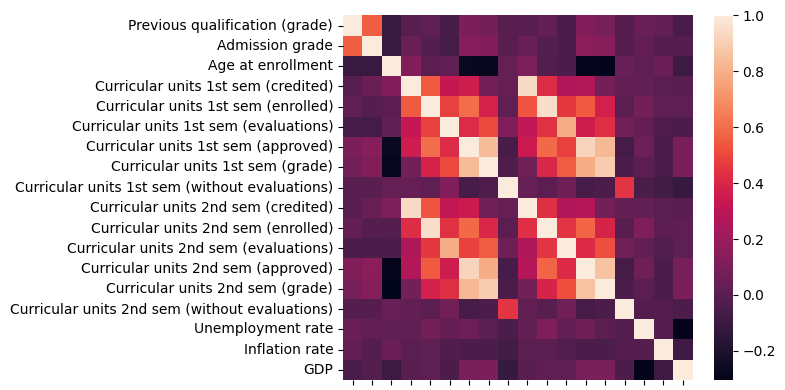

In [50]:
sc.cache_fig('corr_heatmap',
    lambda x:sns.heatmap(df_train[X_num].corr().rename(columns=lambda x: ''), ax=x), 
    figsize=(8, 4)
)

## Curricular 변수들

In [51]:
X_curr = [i for i in X_num if i.startswith('Curricular')]
X_curr

['Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)']

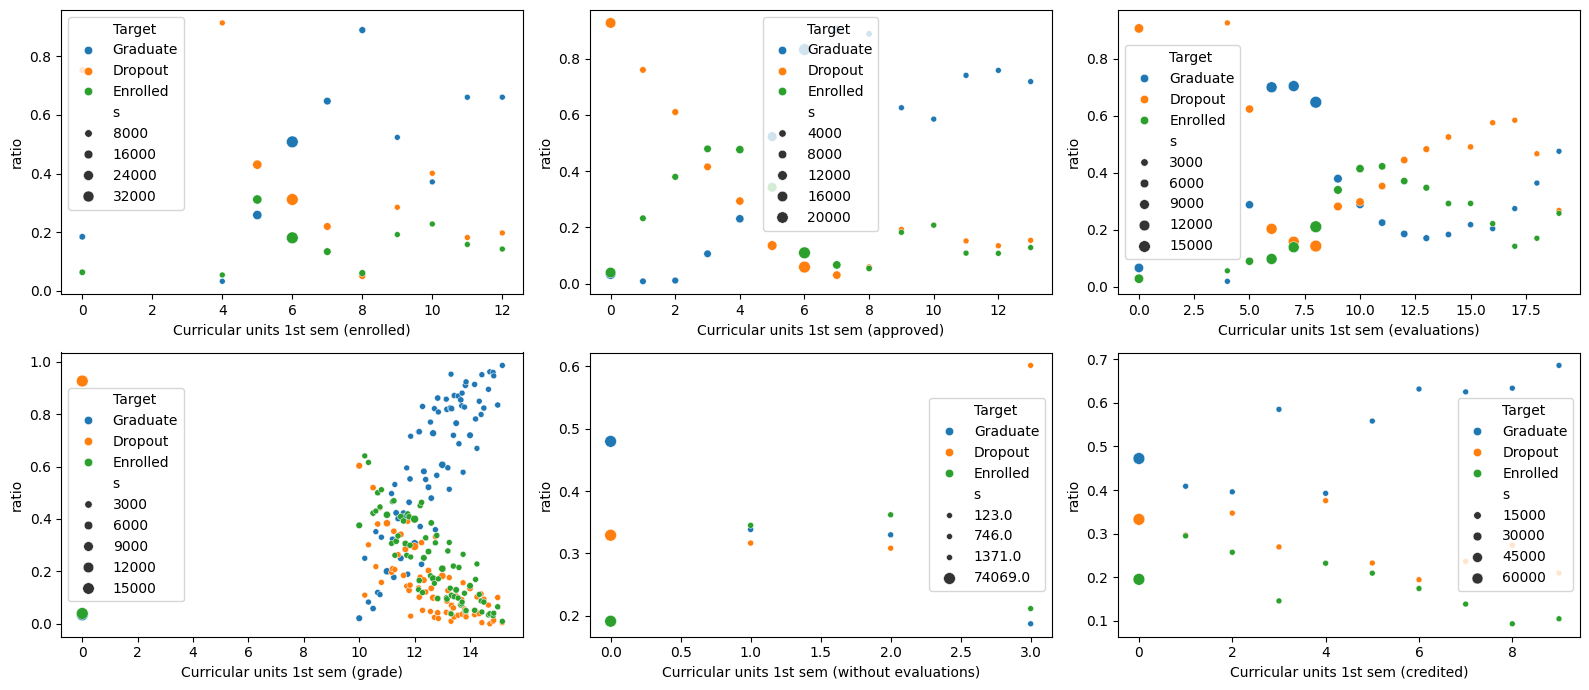

In [122]:
cur_1st = [
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 1st sem (credited)'
]

cur_2nd = [
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Curricular units 2nd sem (credited)'
]

def cur_ratio_plot(var, ax):
    df_train.pivot_table(
        index=var, columns=target, aggfunc='size', observed=True
    ).assign(
        s = lambda x: x.sum(axis=1)
    ).pipe(
        lambda x: x.loc[x['s'] >= 100]
    ).fillna(0).assign(
        Graduate = lambda x: x['Graduate'] / x['s'],
        Dropout = lambda x: x['Dropout'] / x['s'],
        Enrolled = lambda x: x['Enrolled'] / x['s'],
    ).reset_index().melt(id_vars=[var, 's']).rename(
        columns={'value': 'ratio'}
    ).pipe(
        lambda x: sns.scatterplot(x, x=var, y='ratio', hue=target, size='s', ax=ax)
    )
sc.cache_fig('cur_1st_target',
    lambda x: [cur_ratio_plot(i, ax) for i, ax in zip(cur_1st, x)],
    nrow=2, ncol=3, figsize=(16, 7)
)

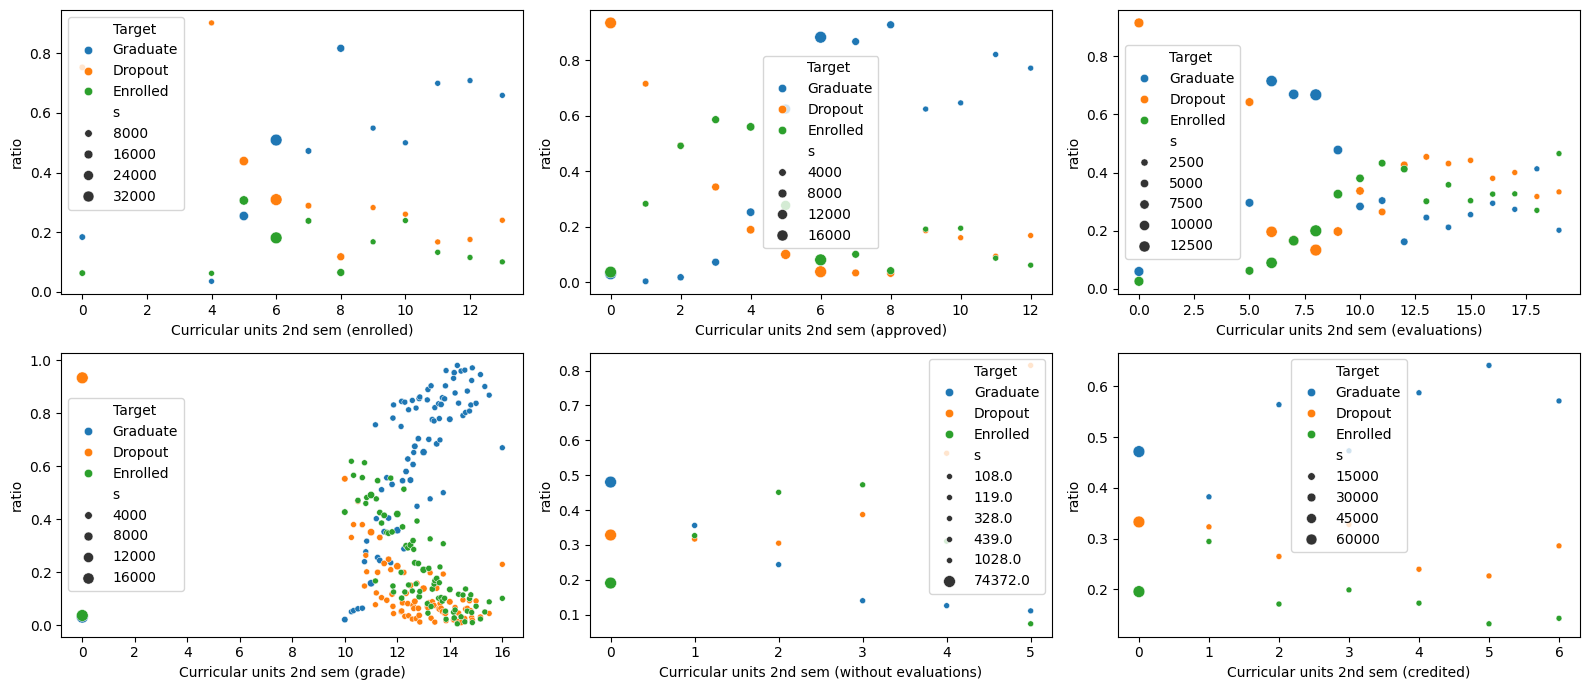

In [124]:
sc.cache_fig('cur_2st_target',
    lambda x: [cur_ratio_plot(i, ax) for i, ax in zip(cur_2nd, x)],
    nrow=2, ncol=3, figsize=(16, 7)
)

In [ ]:
df_train.pivot_table(
    index=['Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (credited)'],
    columns=[target], aggfunc='size', observed=True
).fillna(0).assign(
    s = lambda x: x.sum(axis=1)
).pipe(lambda x: x.loc[x['s'] >= 30])

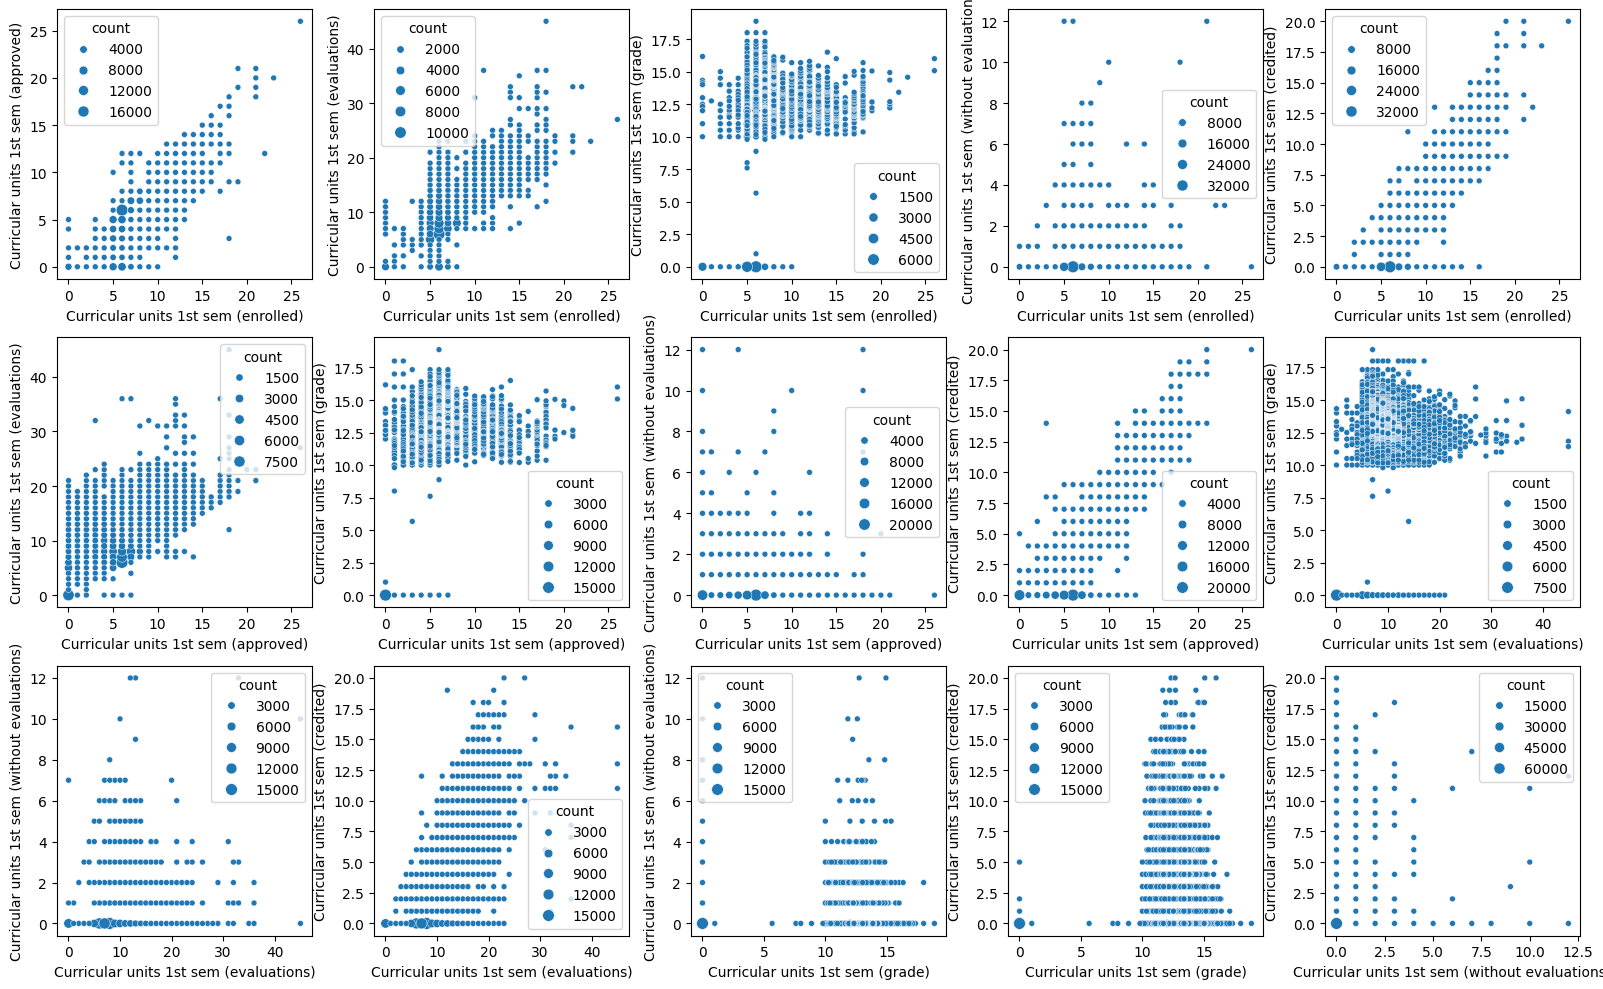

In [94]:
import itertools

def curr_2d_plot(a, b, ax):
    df_train[[a, b]].value_counts().reset_index().pipe(
        lambda x: sns.scatterplot(data=x, x = a, y = b, size = 'count', ax=ax)
    )

sc.cache_fig(
    'cur_2d_plots_1st', 
    lambda x: [
        curr_2d_plot(a, b, ax) for (a, b), ax in zip(itertools.combinations(cur_1st, 2), x)
    ], nrow=3, ncol=5, figsize=(16, 10)
)

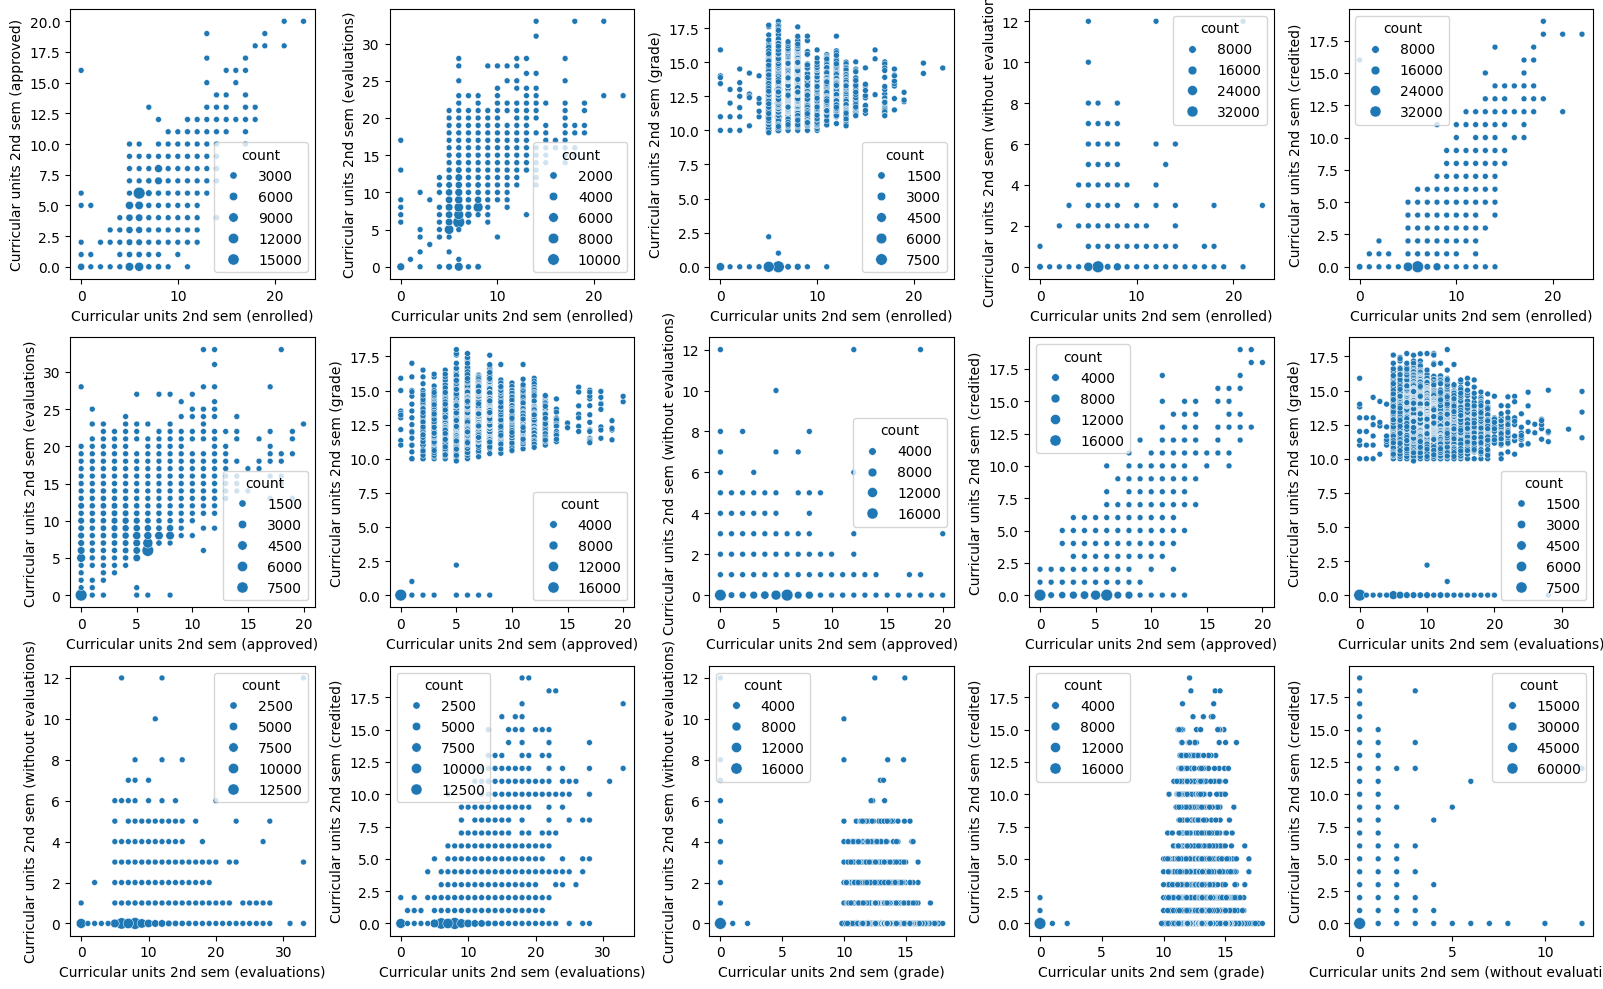

In [102]:
sc.cache_fig(
    'cur_2d_plots_2nd', 
    lambda x: [
        curr_2d_plot(a, b, ax) for (a, b), ax in zip(itertools.combinations(cur_2st, 2), x)
    ], nrow=3, ncol=5, figsize=(16, 10)
)

In [73]:
3 * 5 

15